## **Notebook EC03**
## Regularized ELM Classifier for the MNIST database. Designed from scratch.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** teste


In [66]:
from matplotlib import pyplot as plt
import numpy as np
#from keras.datasets import mnist
from keras.datasets import cifar10

(Xp, y), (Xtp, yt) = cifar10.load_data()
Xa = Xp.reshape(Xp.shape[0], 3072)
Xta = Xtp.reshape(Xtp.shape[0], 3072)
y = y.ravel()
yt = yt.ravel()
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

Shape of X:  (50000, 3072)
Shape of y:  (50000,)
Shape of Xt:  (10000, 3072)
Shape of yt:  (10000,)


In [67]:
from tensorflow.keras.utils import to_categorical

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)

[5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [68]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (35000, 3072)
y_training:          (35000, 10)
X_validation:        (15000, 3072)
y_validation:        (15000, 10)
X_training_elm:      (35000, 3073)
X_validation_elm:    (15000, 3073)


In [69]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_

In [70]:
def leaky_relu(table):
    return np.where(table > 0, table,  0.02 * table)

def relu(table):
    return np.where(table > 0, table,  0)

def get_h(X, V, activation_function):
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, y, c):
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w

In [71]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []

    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)

        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [72]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs for the MNIST dataset: 785
# Number of inputs for the CIFAR10 dataset: 3073
# Take 1000 hidden neurons for the MNIST dataset and 2000 for the CIFAR10 dataset.
V  = sigma * np.random.randn(3073, 2000)

In [83]:
c_values = [pow(2,d) for d in range(-16, 14, 2)]

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096


In [84]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096


Best c value: 4096 
Performance of this value: 0.46273333333333333


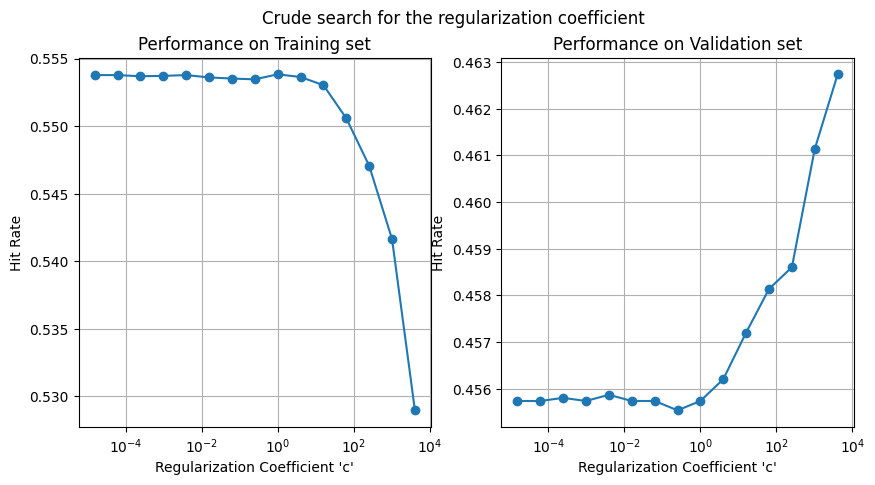

In [85]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


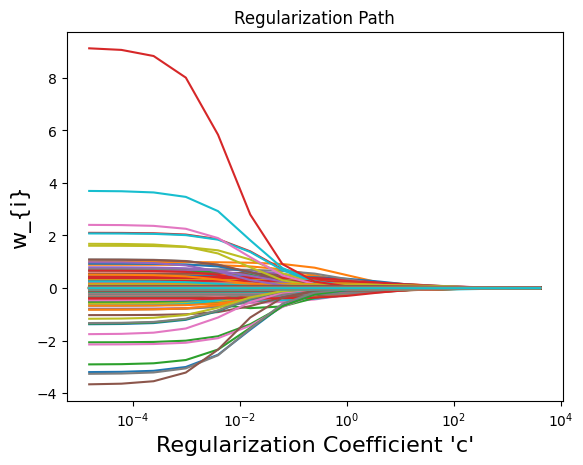

In [76]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=16)
    plt.ylabel(r"w_{i}", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [77]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


In [78]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

1024.0
2560.0
4096.0
5632.0
7168.0
8704.0
10240.0
11776.0
13312.0
14848.0
16384.0


Best c value: 4096.0 
Performance of this value: 0.46273333333333333


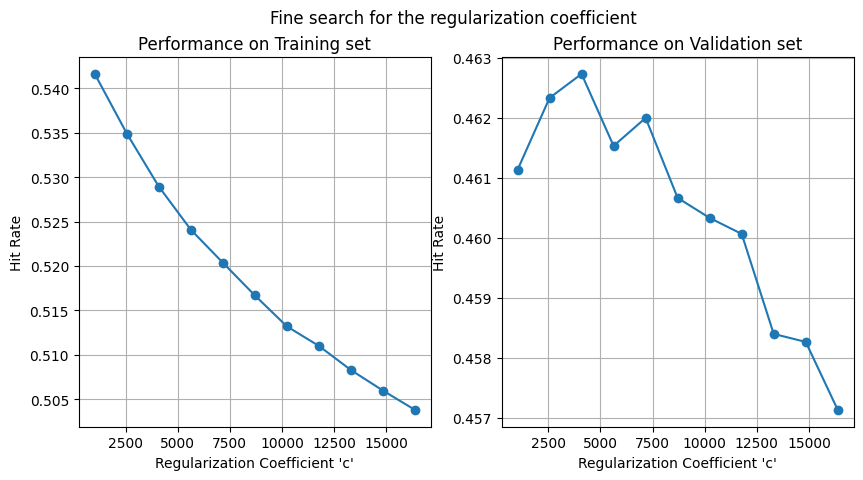

In [79]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [80]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [81]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
print(confusion_matrix)

Performance on test set: 0.4704
[[533  39 107  44  62  38  17  43  96  47]
 [ 49 578  47  51  27  37  40  45  75 180]
 [ 42   9 314  74 123  90  78  38  14  10]
 [  7  20  66 257  34 157  51  53  19  21]
 [ 22  15 110  41 372  55  82  63  11   9]
 [ 22  21  64 191  49 349  53  57  23  20]
 [ 29  28 135 151 153 102 592  48  16  38]
 [ 40  40  90  76 110  91  34 520  23  53]
 [198  69  41  46  45  43  20  35 656  89]
 [ 58 181  26  69  25  38  33  98  67 533]]


Image no. 1


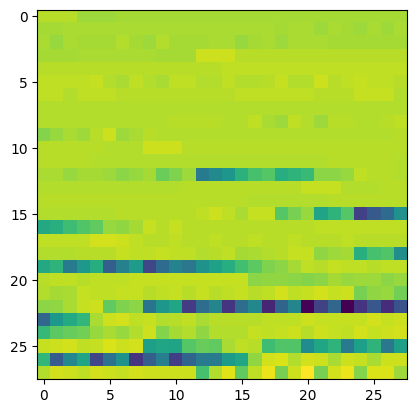

Real: 8
Predicted: 9
Rank of the correct answer: 3
Probabilities: [ 0.16388022  0.3146439  -0.07148644  0.02232434  0.0116743  -0.03937351
 -0.01422724 -0.15808735  0.31092694  0.50380142] 

Image no. 3


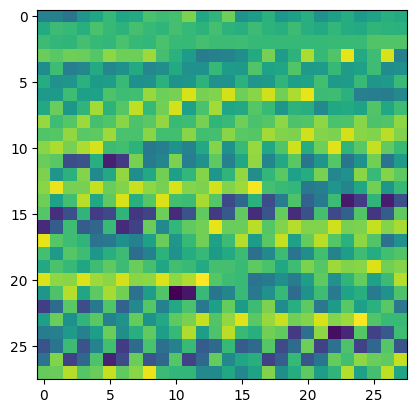

Real: 0
Predicted: 8
Rank of the correct answer: 3
Probabilities: [ 0.16704361  0.15052442  0.14343596  0.02891359  0.17179024 -0.00371303
 -0.07135794  0.08710625  0.28994512  0.05732576] 

Image no. 4


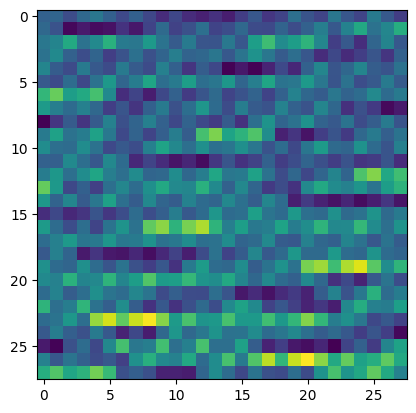

Real: 6
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.03721592  0.09164848  0.11482619 -0.00495252  0.47809748  0.12422452
  0.14928029  0.04716965  0.11289593 -0.09667987] 

Image no. 8


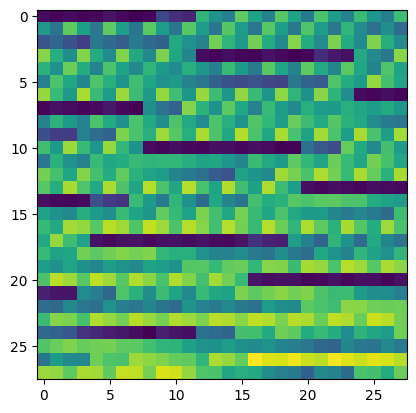

Real: 3
Predicted: 2
Rank of the correct answer: 3
Probabilities: [0.10108806 0.05042829 0.27463721 0.15861504 0.11692702 0.23257046
 0.0589665  0.05020261 0.00458916 0.01301614] 

Image no. 12


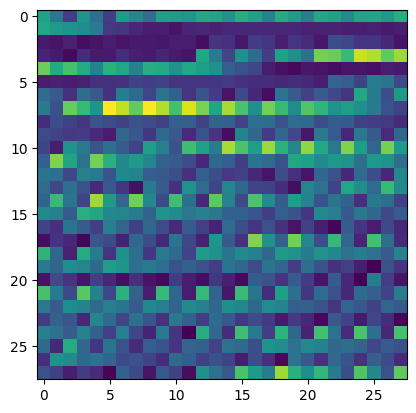

Real: 5
Predicted: 1
Rank of the correct answer: 5
Probabilities: [-0.04151194  0.28674421  0.0492879   0.15575571  0.02286557  0.10367501
  0.13810329  0.07765416  0.15652117  0.05401333] 

Image no. 17


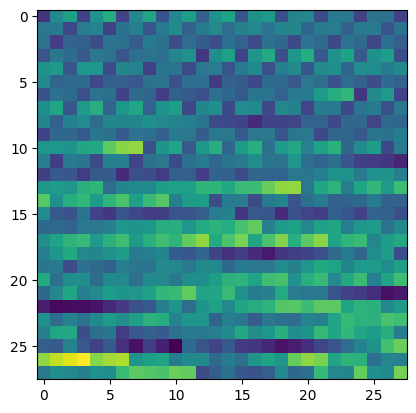

Real: 7
Predicted: 0
Rank of the correct answer: 7
Probabilities: [0.19428635 0.05647742 0.16177602 0.19031047 0.09999355 0.01195283
 0.16277    0.06746022 0.11003781 0.06279208] 

Image no. 20


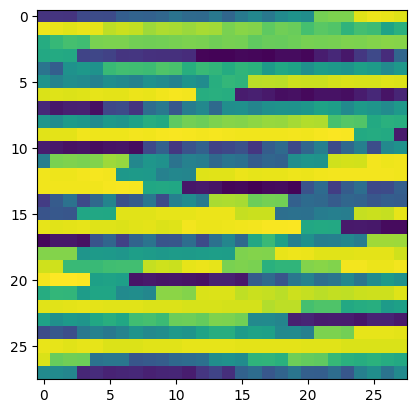

Real: 7
Predicted: 1
Rank of the correct answer: 4
Probabilities: [ 0.05870599  0.24492445  0.02242919  0.09698061  0.2285456   0.08992486
 -0.16144424  0.0993122   0.04683082  0.185803  ] 

Image no. 22


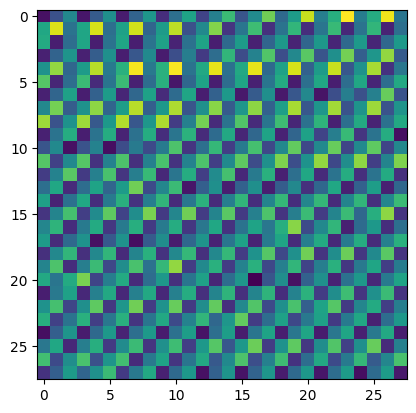

Real: 4
Predicted: 0
Rank of the correct answer: 3
Probabilities: [ 0.45896503  0.01701353  0.18466526 -0.03300145  0.11914525 -0.02606542
  0.08019224 -0.05452601  0.08191341 -0.00522873] 

Image no. 24


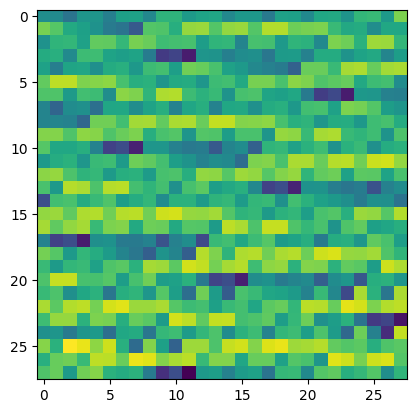

Real: 5
Predicted: 4
Rank of the correct answer: 5
Probabilities: [ 0.22813313 -0.01982914  0.20797495 -0.01649937  0.39469185  0.01649296
  0.00408019  0.18695303  0.01633808 -0.04882785] 

Image no. 25


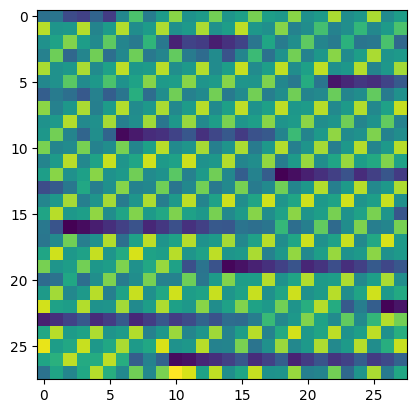

Real: 2
Predicted: 6
Rank of the correct answer: 4
Probabilities: [-0.07038087  0.22259143  0.17614785  0.06002741  0.15083585  0.15606734
  0.33123741 -0.11374282  0.18148421 -0.11237077] 

Image no. 31


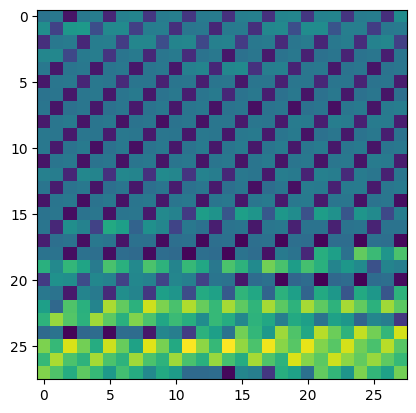

Real: 5
Predicted: 4
Rank of the correct answer: 3
Probabilities: [ 0.07989797 -0.02371935  0.17450303  0.04757804  0.22463395  0.15452116
  0.09812812  0.11422133  0.04853679  0.05752915] 

Image no. 32


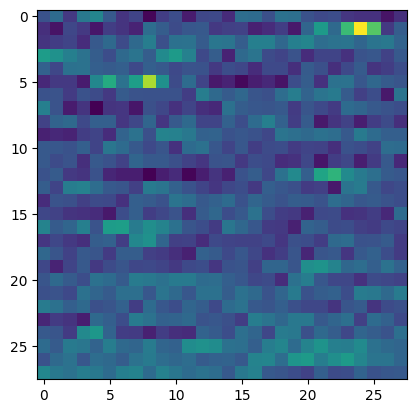

Real: 4
Predicted: 5
Rank of the correct answer: 7
Probabilities: [ 0.10466781 -0.00900281  0.18966608  0.10485351  0.0979595   0.19623591
  0.17741058  0.05820082  0.11497857 -0.09097836] 

Image no. 33


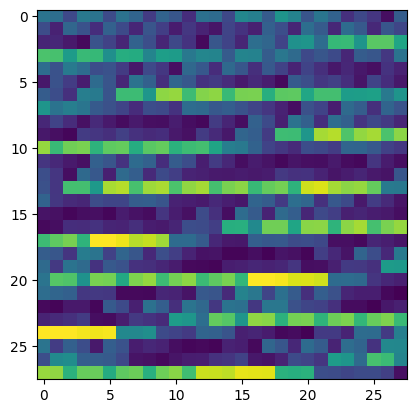

Real: 5
Predicted: 2
Rank of the correct answer: 5
Probabilities: [ 0.00496865  0.1817851   0.27876589  0.18976473  0.09708993  0.10309719
  0.19630155 -0.02670302  0.06050558 -0.14990741] 

Image no. 35


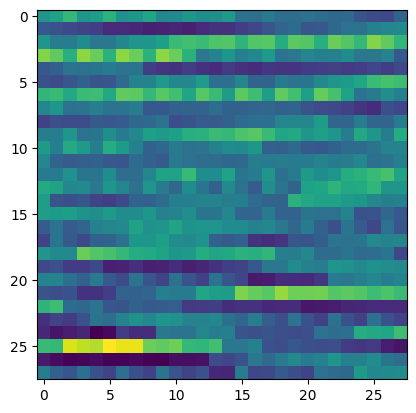

Real: 2
Predicted: 1
Rank of the correct answer: 2
Probabilities: [ 0.01852915  0.32174448  0.21565302  0.00488496  0.0381695   0.11948929
  0.13787229 -0.02338002  0.12422042  0.09632175] 

Image no. 37


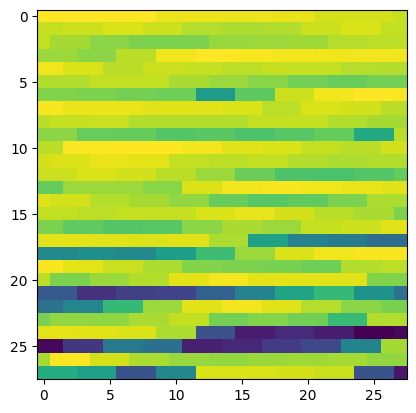

Real: 1
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.10234975  0.30346802 -0.13543393  0.12963078 -0.01430762  0.14226356
  0.02434871 -0.00713581  0.07604269  0.50833769] 

Image no. 38


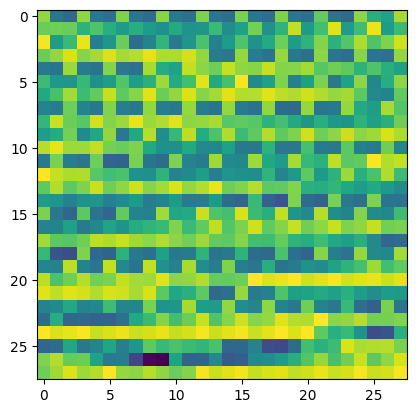

Real: 9
Predicted: 8
Rank of the correct answer: 4
Probabilities: [ 0.03349786  0.17263035  0.0438938   0.14751077  0.12407185  0.04932115
  0.11254175 -0.04184545  0.18266118  0.14667391] 

Image no. 40


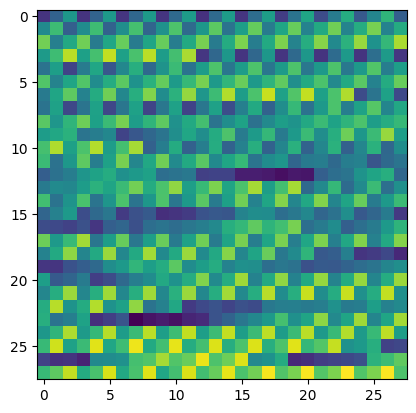

Real: 4
Predicted: 0
Rank of the correct answer: 4
Probabilities: [ 0.34990444  0.25255635  0.03692578 -0.08104355  0.22380515 -0.01525978
  0.0435637   0.24150442  0.07049479  0.00901363] 

Image no. 42


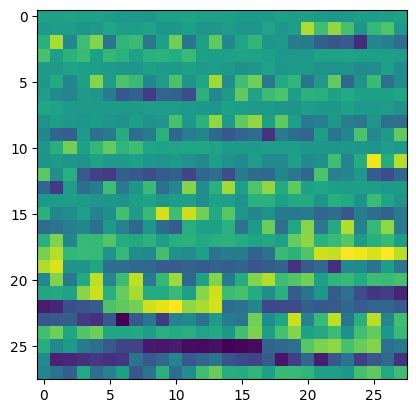

Real: 5
Predicted: 3
Rank of the correct answer: 3
Probabilities: [ 0.08030284 -0.04562359  0.020749    0.28815503 -0.00459698  0.15780982
  0.02772929  0.11247355  0.06626216  0.22786054] 

Image no. 44


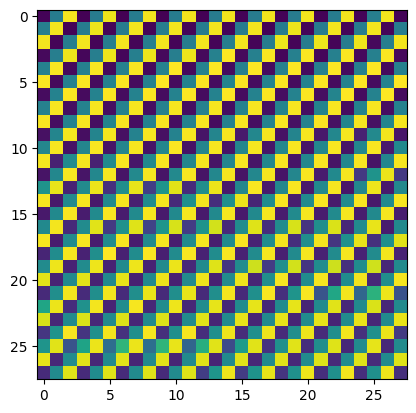

Real: 0
Predicted: 8
Rank of the correct answer: 3
Probabilities: [ 0.25162572  0.03357373  0.07827968  0.01266468  0.07238818 -0.03627126
 -0.06481168  0.33364816  0.35772232  0.10505509] 

Image no. 46


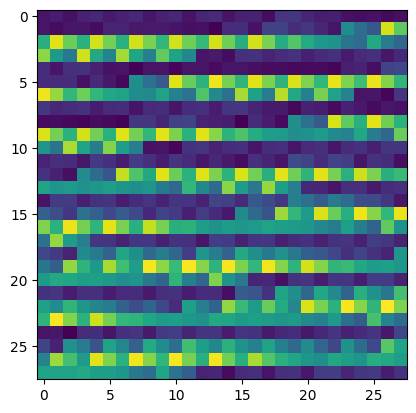

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [-0.14936544  0.05712473  0.0649235   0.2858944   0.0862831   0.33155737
  0.20514669 -0.03217903  0.01136377  0.16249082] 

Image no. 47


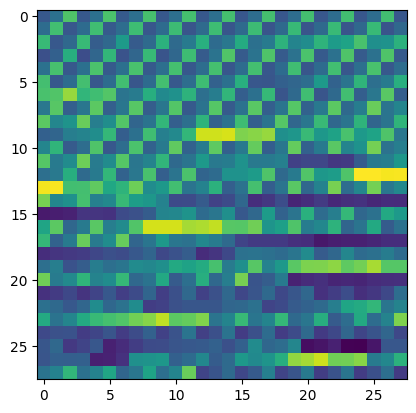

Real: 9
Predicted: 8
Rank of the correct answer: 6
Probabilities: [ 0.2004269   0.07142078 -0.11509254  0.12926683  0.06963679  0.0427239
  0.0905337   0.08427292  0.32424065  0.07406271] 

Image no. 48


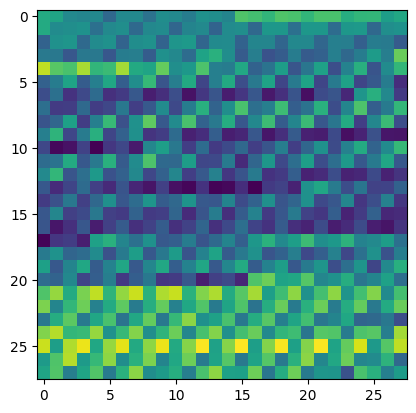

Real: 7
Predicted: 4
Rank of the correct answer: 4
Probabilities: [ 0.04088554  0.03292458  0.19189658 -0.0184805   0.36600703  0.04015042
  0.18429318  0.12929511 -0.05304876  0.02517466] 

Image no. 52


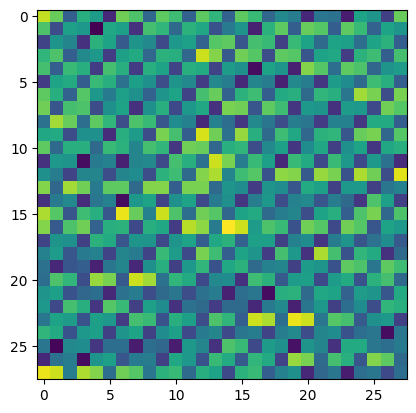

Real: 0
Predicted: 6
Rank of the correct answer: 6
Probabilities: [ 0.07000415  0.065294    0.08429648  0.14357251  0.06958513  0.09230046
  0.31930338 -0.00504059  0.08221004  0.03475588] 

Image no. 56


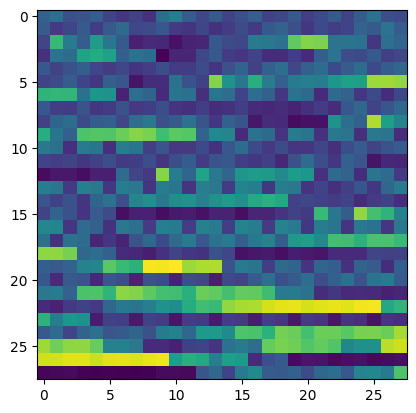

Real: 7
Predicted: 4
Rank of the correct answer: 7
Probabilities: [ 0.15085784  0.00359375  0.1674251   0.1426968   0.24209979  0.08625411
  0.21077407  0.09842157 -0.08546923  0.18557879] 

Image no. 57


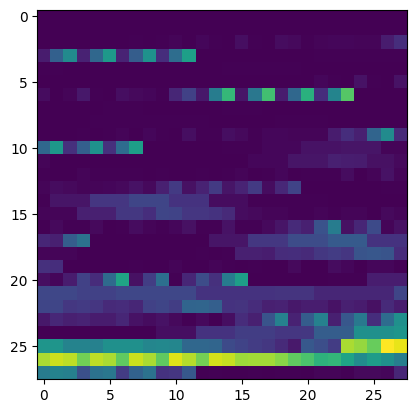

Real: 7
Predicted: 6
Rank of the correct answer: 3
Probabilities: [ 0.103448    0.14907575 -0.02442124 -0.03971984 -0.08116431 -0.01821252
  0.30589191  0.18697511  0.16222551  0.19396681] 

Image no. 58


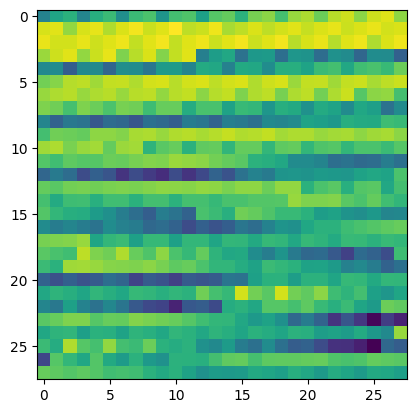

Real: 4
Predicted: 9
Rank of the correct answer: 3
Probabilities: [-0.02217805  0.01017731  0.1006719   0.10859037  0.12771613  0.11156561
  0.04496317  0.12394489  0.1514875   0.22420723] 

Image no. 59


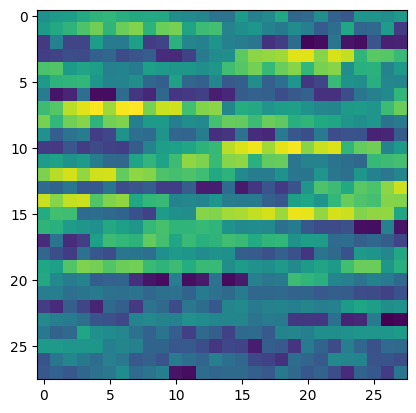

Real: 6
Predicted: 2
Rank of the correct answer: 5
Probabilities: [ 0.17492568  0.04706808  0.27034935  0.12853067  0.23933143  0.04065425
  0.09280274 -0.09702003  0.03644204  0.00333191] 

Image no. 60


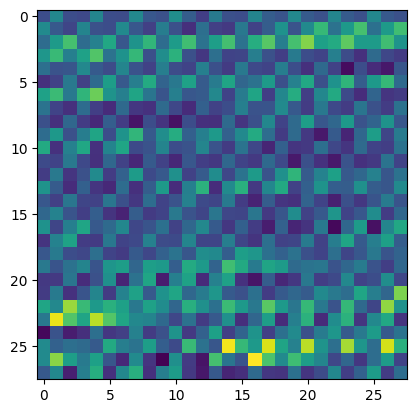

Real: 7
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.07154403 -0.16976773  0.13994338 -0.01959678  0.47040159  0.10277125
  0.14199862  0.36041545 -0.08557397  0.05241339] 

Image no. 62


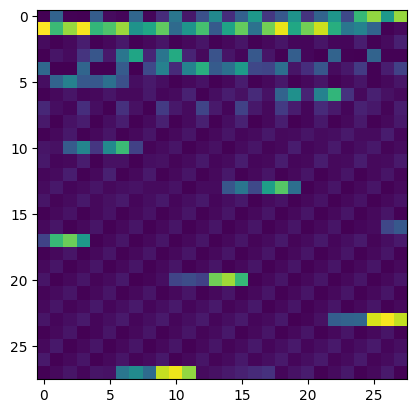

Real: 6
Predicted: 1
Rank of the correct answer: 3
Probabilities: [ 0.07622687  0.35415087  0.11662794  0.0088849   0.19703304  0.02515901
  0.19657549  0.02615934 -0.02011484  0.0717384 ] 

Image no. 63


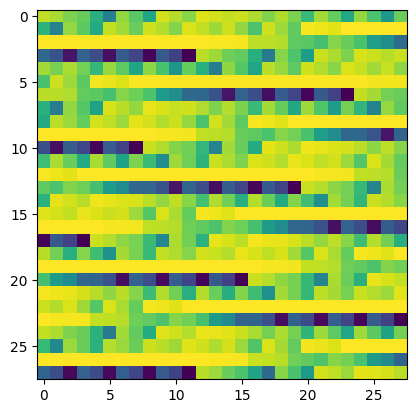

Real: 3
Predicted: 9
Rank of the correct answer: 6
Probabilities: [-0.05154011  0.16469518  0.13805246  0.12319063  0.09776726  0.14452189
  0.04439376 -0.04795927  0.18829758  0.355971  ] 

Image no. 64


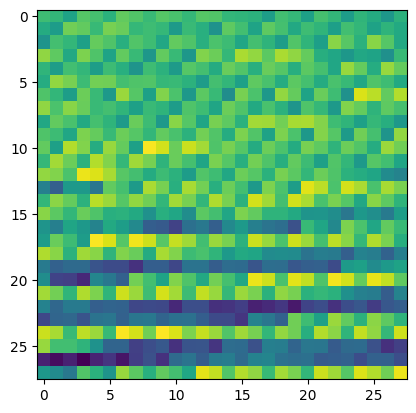

Real: 6
Predicted: 2
Rank of the correct answer: 2
Probabilities: [ 0.04693299  0.13042364  0.20440243  0.12230236  0.12948491  0.1099268
  0.15801229 -0.01345956 -0.02496397  0.07255398] 

Image no. 67


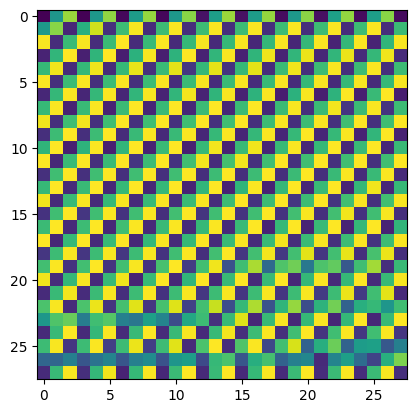

Real: 2
Predicted: 8
Rank of the correct answer: 2
Probabilities: [ 0.30932152 -0.1480252   0.35427371 -0.0727406  -0.16862478 -0.04960322
  0.12664128  0.10248632  0.44614742  0.03144784] 

Image no. 68


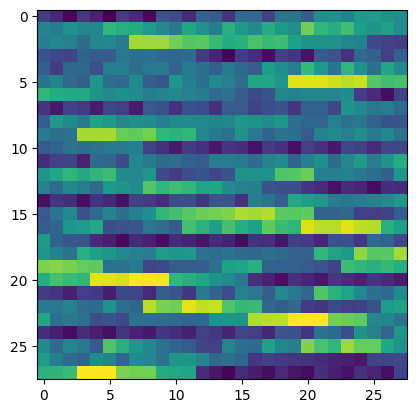

Real: 3
Predicted: 5
Rank of the correct answer: 3
Probabilities: [-0.10665518  0.17809409  0.13123789  0.18162804  0.00078106  0.27157212
  0.01046934  0.15141292 -0.0300499   0.26326941] 

Image no. 69


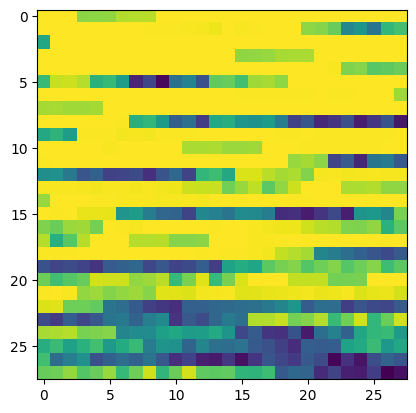

Real: 7
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.1534823   0.18744727  0.00959603 -0.05068933  0.00678928  0.03908043
 -0.14222936  0.24449609  0.08918908  0.42754786] 

Image no. 71


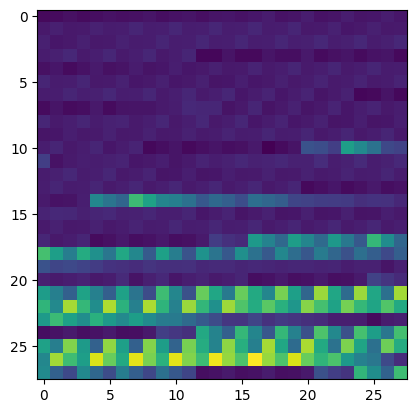

Real: 6
Predicted: 7
Rank of the correct answer: 2
Probabilities: [-0.07818078  0.08760342  0.14819386  0.0784323   0.17820094  0.17862235
  0.18865705  0.27810451 -0.14194955  0.07699559] 

Image no. 74


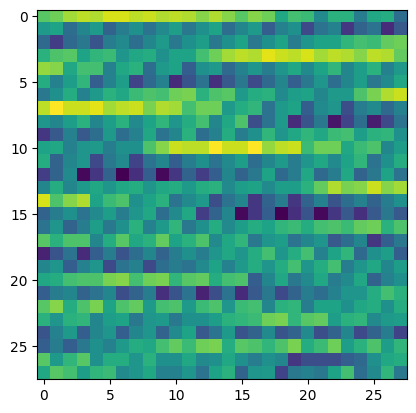

Real: 0
Predicted: 7
Rank of the correct answer: 2
Probabilities: [ 0.25960887  0.00647584  0.04663211  0.02081929  0.08040405 -0.04516795
  0.06767913  0.29026477  0.13150703  0.18401133] 

Image no. 77


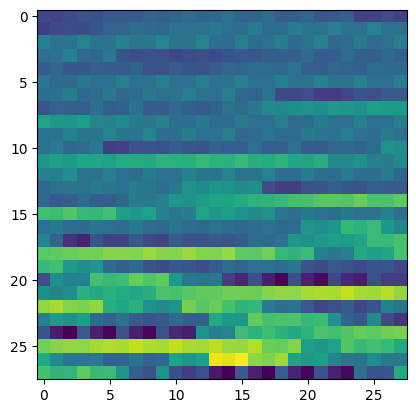

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [ 0.00445841  0.08003882  0.06040025  0.26980011 -0.07136653  0.30367387
  0.01709465  0.02633598  0.20706204  0.02140718] 

Image no. 83


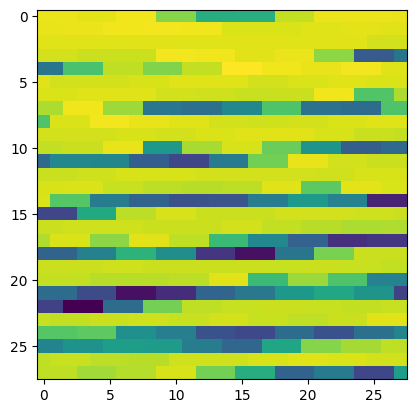

Real: 7
Predicted: 0
Rank of the correct answer: 6
Probabilities: [ 0.18396593  0.06646186  0.17519734  0.12669292  0.02714134  0.128238
 -0.01937012  0.1110224   0.14122315  0.09980546] 

Image no. 85


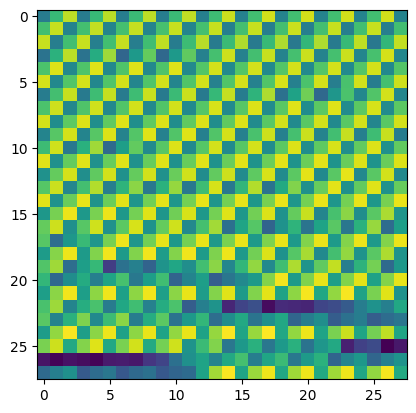

Real: 5
Predicted: 9
Rank of the correct answer: 4
Probabilities: [ 0.1302694  -0.06326743  0.03097431  0.03213975  0.00797223  0.08449513
 -0.02501986  0.3383788   0.01327963  0.34989204] 

Image no. 87


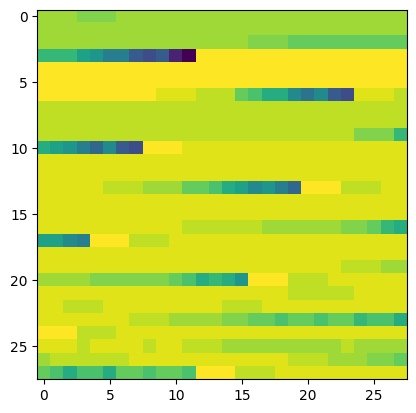

Real: 7
Predicted: 8
Rank of the correct answer: 9
Probabilities: [ 0.21794227  0.0757801   0.0576075   0.08167596  0.08744027  0.09653269
 -0.01292532 -0.00061677  0.38439955  0.09408023] 

Image no. 90


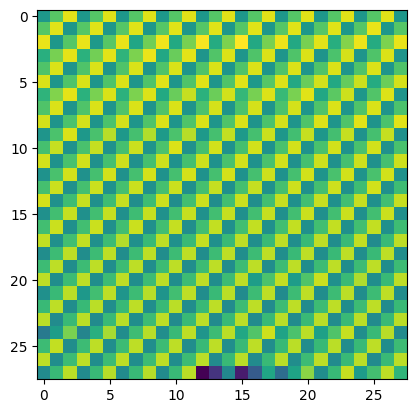

Real: 0
Predicted: 8
Rank of the correct answer: 2
Probabilities: [ 0.24366026  0.11240538  0.07558567 -0.06860933  0.03762586 -0.00503434
 -0.08146642  0.04770964  0.34166339  0.24064741] 

Image no. 91


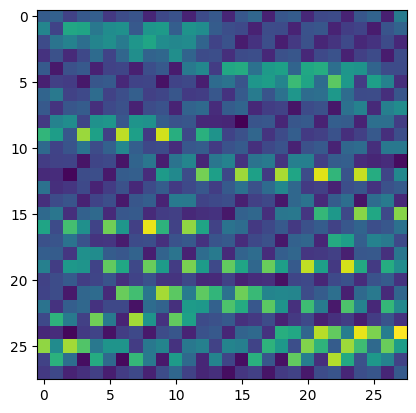

Real: 3
Predicted: 6
Rank of the correct answer: 6
Probabilities: [ 0.08501911 -0.09887366  0.13922707  0.11095494  0.20274899  0.15090416
  0.22184753  0.11317518 -0.09376542  0.05660902] 

Image no. 94


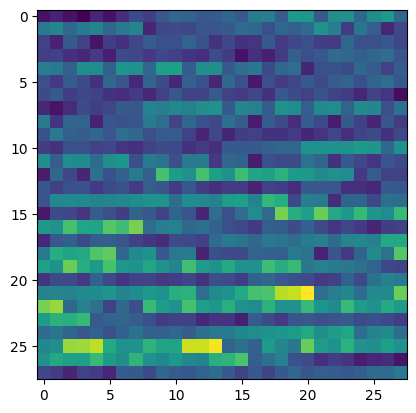

Real: 4
Predicted: 7
Rank of the correct answer: 2
Probabilities: [ 0.12215168 -0.02417156  0.11636492 -0.01229468  0.18975114  0.05126697
  0.13794564  0.2073571   0.13812092 -0.07248292] 

Image no. 95


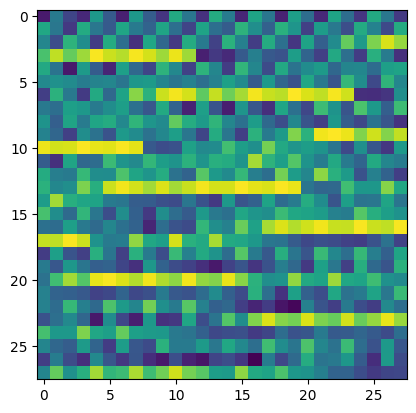

Real: 6
Predicted: 2
Rank of the correct answer: 6
Probabilities: [-0.02719491 -0.05827414  0.30956587  0.18504261  0.12861096  0.08282756
  0.09866625  0.11165613  0.01240862  0.0992395 ] 

Image no. 99


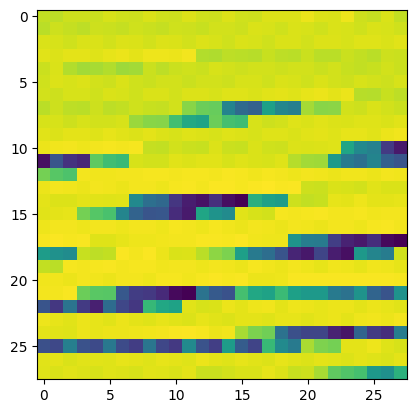

Real: 7
Predicted: 9
Rank of the correct answer: 3
Probabilities: [ 0.14040428 -0.0731584   0.25164235  0.15932222  0.02256544  0.08487485
 -0.09141506  0.21170394 -0.09750256  0.46722254] 

Image no. 100


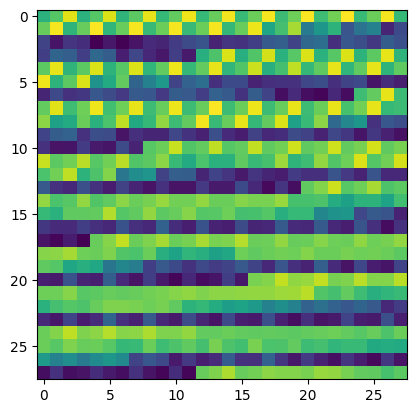

Real: 4
Predicted: 5
Rank of the correct answer: 2
Probabilities: [0.09708575 0.01904649 0.12173261 0.11458044 0.16532152 0.1718617
 0.01662238 0.11409737 0.03143969 0.08276895] 

Image no. 101


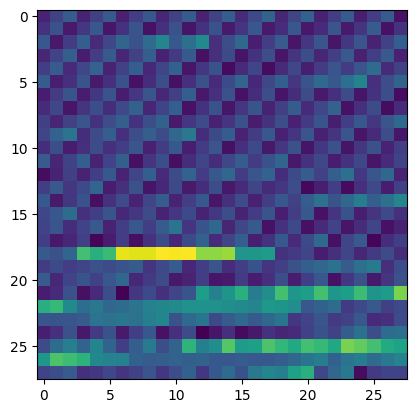

Real: 5
Predicted: 4
Rank of the correct answer: 7
Probabilities: [0.00945355 0.15796378 0.06306316 0.00264901 0.26892665 0.04054904
 0.01530739 0.17956672 0.07539812 0.13139054] 

Image no. 106


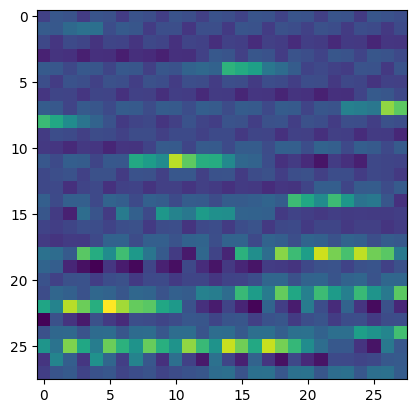

Real: 3
Predicted: 6
Rank of the correct answer: 4
Probabilities: [0.07425691 0.05692301 0.01738917 0.0924462  0.01732789 0.18088927
 0.33042831 0.05328458 0.1012254  0.04634191] 

Image no. 109


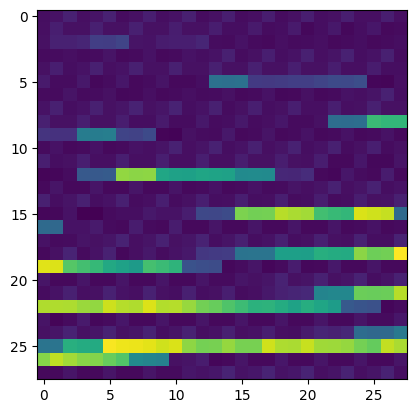

Real: 7
Predicted: 5
Rank of the correct answer: 2
Probabilities: [-0.05279185  0.09643382 -0.07850462  0.20202006 -0.01074333  0.41469258
  0.04424485  0.37346648  0.01110923  0.17286482] 

Image no. 110


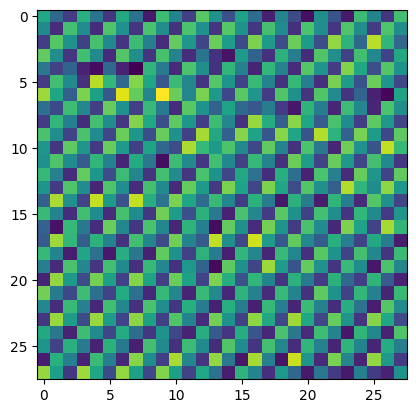

Real: 4
Predicted: 6
Rank of the correct answer: 2
Probabilities: [0.06116393 0.07114065 0.07491023 0.03925131 0.29137022 0.02451038
 0.4986304  0.02511275 0.00389152 0.10247191] 

Image no. 111


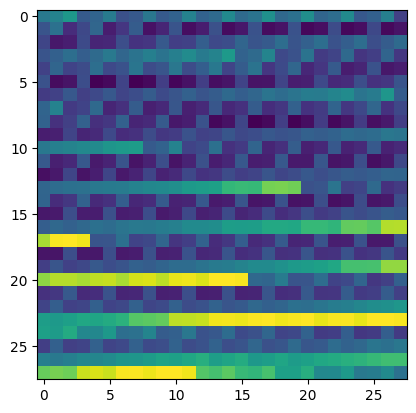

Real: 0
Predicted: 2
Rank of the correct answer: 2
Probabilities: [ 0.33136531  0.08141099  0.3470571   0.20315841  0.0959682   0.20654252
 -0.11698399  0.0677055  -0.08926111 -0.03368094] 

Image no. 114


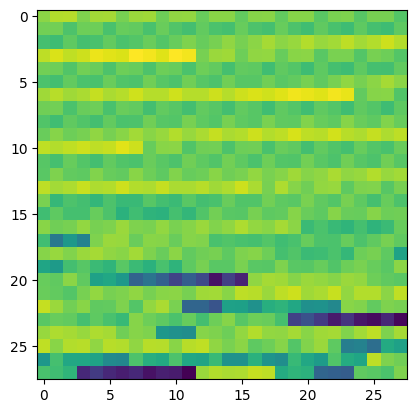

Real: 1
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.2267266   0.25510158 -0.128253   -0.09072814 -0.01234027  0.03392312
  0.01490226  0.18247226  0.05824677  0.44574024] 

Image no. 115


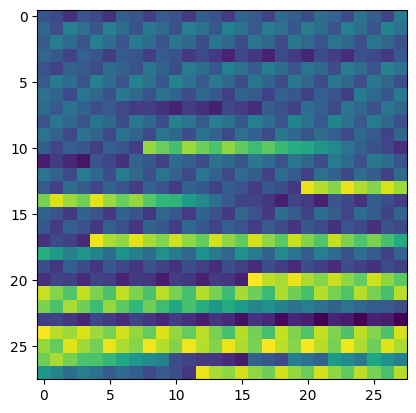

Real: 3
Predicted: 1
Rank of the correct answer: 3
Probabilities: [ 0.11834003  0.26717107  0.04713887  0.13710999  0.07489685  0.00934247
  0.15121553  0.06604779 -0.04128422  0.12423708] 

Image no. 117


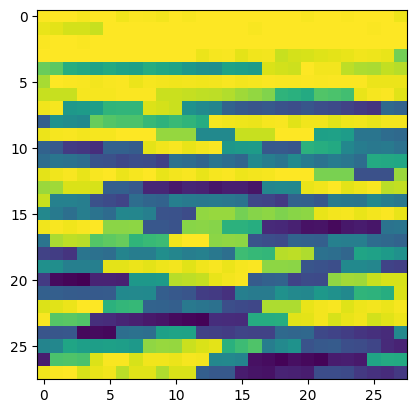

Real: 4
Predicted: 9
Rank of the correct answer: 6
Probabilities: [ 0.06931036  0.03950957  0.12262266  0.10160188  0.08665935  0.18145196
 -0.03434168  0.18265881  0.04427626  0.26948464] 

Image no. 119


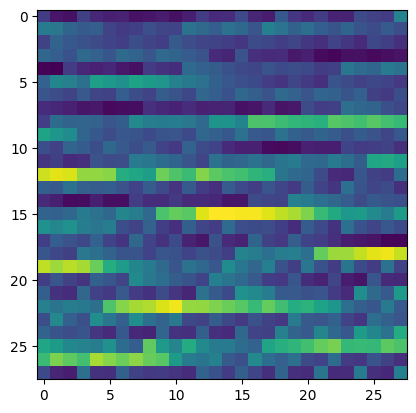

Real: 7
Predicted: 5
Rank of the correct answer: 2
Probabilities: [ 4.59320298e-02 -6.95496595e-02  5.29335874e-02 -9.58031610e-03
  2.46785381e-01  2.77305921e-01  1.40868478e-01  2.54802113e-01
 -1.68741311e-04  2.06762629e-01] 

Image no. 121


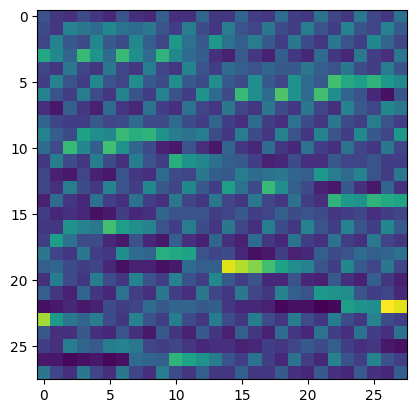

Real: 3
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.01148011  0.00182914  0.00798596  0.20428205  0.3691396   0.15467763
  0.0761241   0.19131969 -0.01567538 -0.07243171] 

Image no. 123


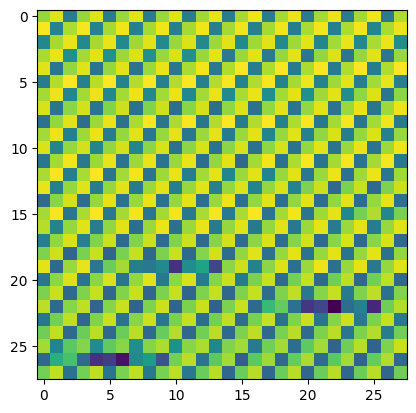

Real: 2
Predicted: 7
Rank of the correct answer: 2
Probabilities: [-0.00701763  0.06001854  0.34859547  0.03467658  0.27704962  0.08683626
  0.06430216  0.35609785 -0.02713604 -0.10871967] 

Image no. 124


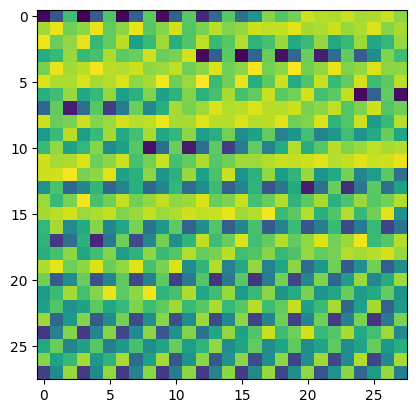

Real: 8
Predicted: 0
Rank of the correct answer: 2
Probabilities: [ 0.41414993  0.02263841  0.03022207  0.00280942  0.05646162 -0.08465585
  0.00274091  0.11238826  0.32724228  0.11039167] 

Image no. 125


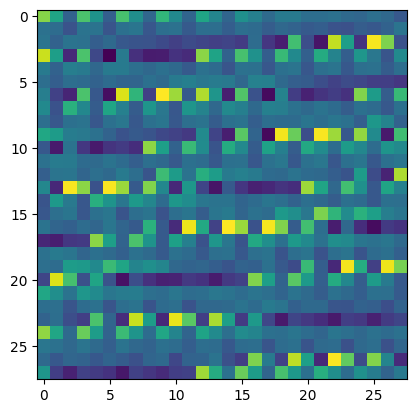

Real: 0
Predicted: 2
Rank of the correct answer: 6
Probabilities: [ 0.05506158  0.19826089  0.20568196  0.14158182 -0.01248617 -0.02136237
  0.11660315  0.13958129 -0.04002473  0.03175288] 

Image no. 127


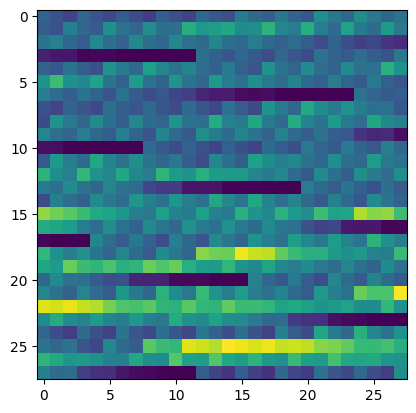

Real: 3
Predicted: 5
Rank of the correct answer: 2
Probabilities: [-0.05014441  0.02261275  0.09757498  0.30404886 -0.04085207  0.35151196
  0.14363791  0.05435885  0.07256335  0.11561786] 

Image no. 128


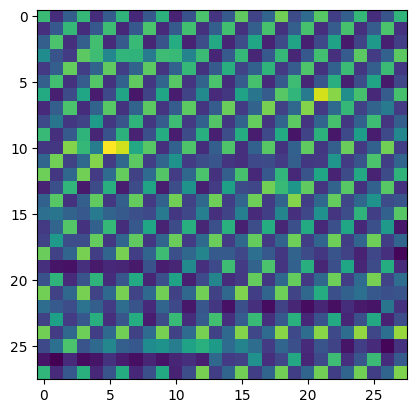

Real: 5
Predicted: 3
Rank of the correct answer: 3
Probabilities: [ 0.04638627  0.05297732  0.07452832  0.32605362  0.30744909  0.20369282
  0.00223184 -0.00246593  0.09758993 -0.03159198] 

Image no. 129


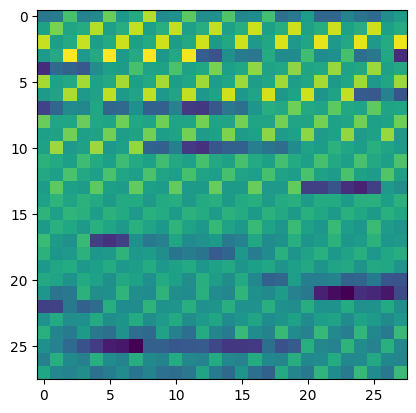

Real: 2
Predicted: 6
Rank of the correct answer: 4
Probabilities: [0.18209044 0.07739812 0.10932194 0.0105045  0.08714464 0.07653478
 0.19592913 0.01424928 0.07120601 0.15894224] 

Image no. 132


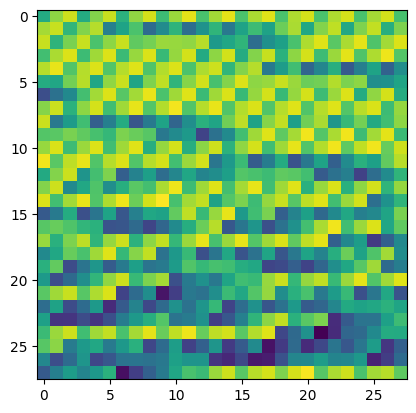

Real: 8
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.0524399   0.21036642 -0.00073943  0.009947   -0.01747601  0.04793918
  0.06785932 -0.12598012  0.22134918  0.4820252 ] 

Image no. 133


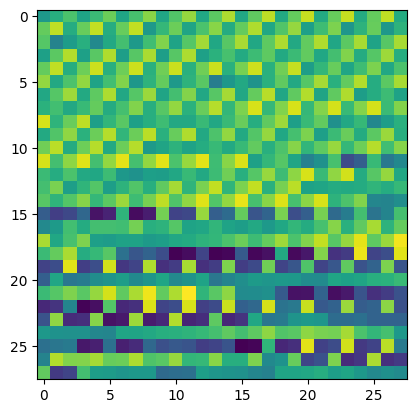

Real: 9
Predicted: 7
Rank of the correct answer: 2
Probabilities: [ 0.07756573  0.31410012 -0.13911641  0.09198935 -0.14193612  0.1241629
 -0.17099483  0.53947933 -0.07270049  0.40559381] 

Image no. 138


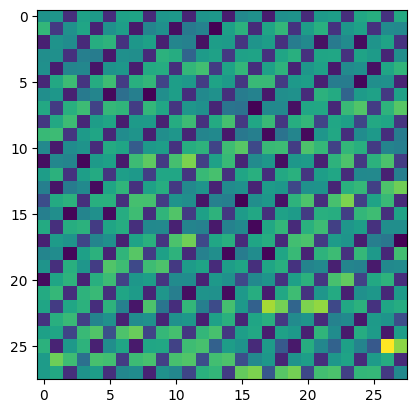

Real: 2
Predicted: 6
Rank of the correct answer: 2
Probabilities: [ 0.03187661 -0.03865397  0.3236694   0.05299762  0.24253381  0.03321991
  0.44203843  0.0260554  -0.09263146 -0.05676034] 

Image no. 139


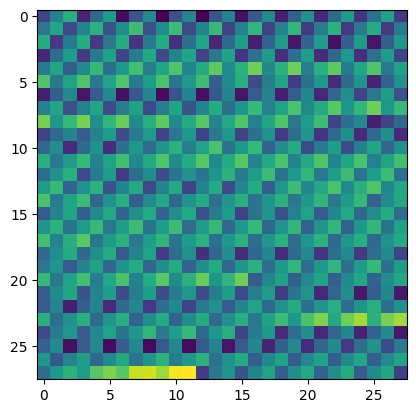

Real: 9
Predicted: 8
Rank of the correct answer: 4
Probabilities: [0.07314028 0.16646588 0.08129059 0.03727093 0.01693934 0.04398188
 0.04620221 0.0217988  0.38065551 0.07729572] 

Image no. 140


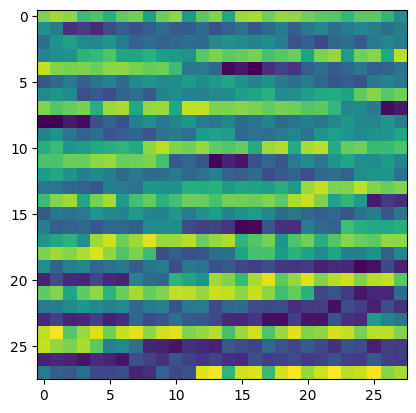

Real: 6
Predicted: 2
Rank of the correct answer: 4
Probabilities: [0.0512154  0.05578799 0.20991138 0.14541707 0.2052744  0.06398448
 0.08554035 0.07044985 0.03657092 0.00794065] 

Image no. 141


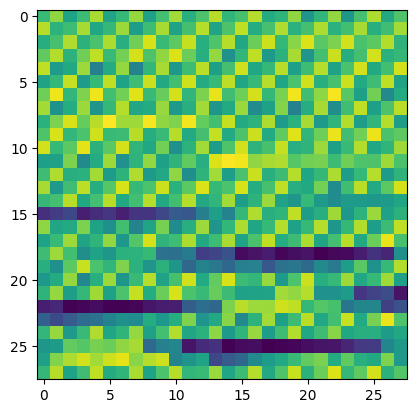

Real: 5
Predicted: 1
Rank of the correct answer: 4
Probabilities: [ 0.0729416   0.34941209  0.07951665  0.04893981 -0.04088169  0.09481906
 -0.07984053  0.13766162  0.22698601  0.04032201] 

Image no. 143


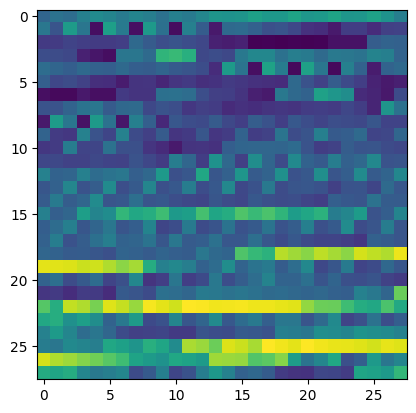

Real: 3
Predicted: 5
Rank of the correct answer: 10
Probabilities: [ 0.11738361  0.12262248  0.10342015 -0.00472723  0.02905345  0.1967548
  0.13447009  0.09578461  0.10811666  0.07225275] 

Image no. 144


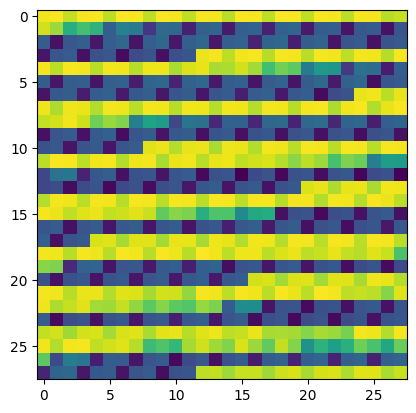

Real: 8
Predicted: 1
Rank of the correct answer: 2
Probabilities: [ 0.10308301  0.3754269  -0.07956772  0.16206381  0.04618954  0.13984249
 -0.00245368 -0.13382961  0.24409883  0.16679587] 

Image no. 146


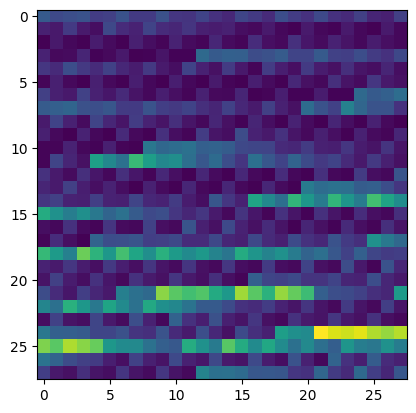

Real: 6
Predicted: 7
Rank of the correct answer: 2
Probabilities: [ 0.03165114 -0.07599398  0.09487001  0.15455294  0.0249935   0.15807287
  0.19185301  0.25097337 -0.10277614  0.05641312] 

Image no. 147


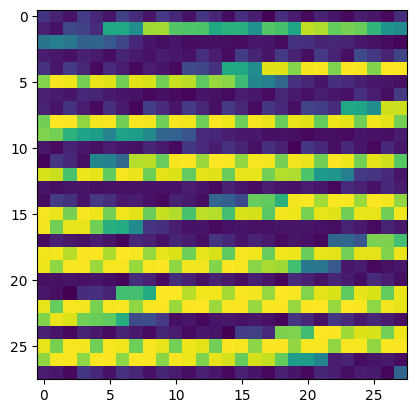

Real: 2
Predicted: 5
Rank of the correct answer: 4
Probabilities: [-0.06748439 -0.01700043  0.17786635  0.16744218 -0.04494183  0.57667304
  0.31096668  0.02052474 -0.17145184  0.18550191] 

Image no. 148


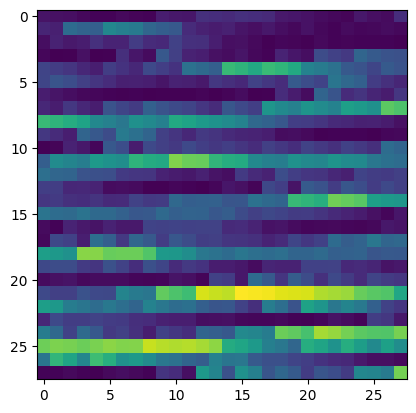

Real: 5
Predicted: 7
Rank of the correct answer: 2
Probabilities: [0.1066749  0.09620338 0.03348494 0.16573868 0.0524429  0.21533454
 0.12378096 0.25602836 0.04305545 0.04504147] 

Image no. 149


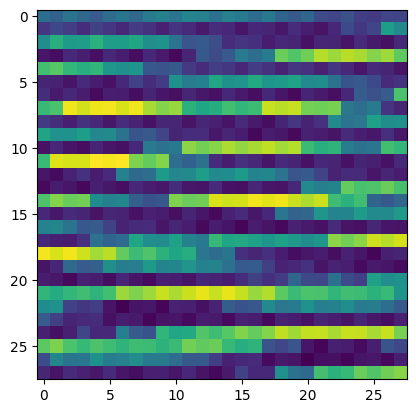

Real: 2
Predicted: 1
Rank of the correct answer: 4
Probabilities: [ 0.10928587  0.20140578  0.14092671  0.14477166 -0.0364644   0.15294
  0.05679467  0.01678539  0.12105411  0.07686546] 

Image no. 150


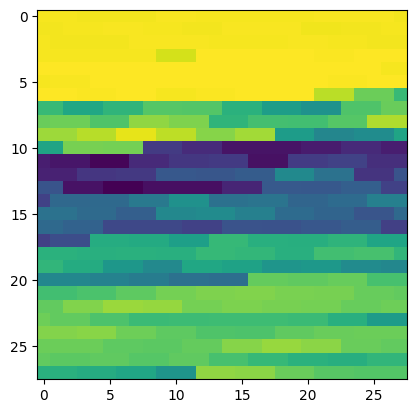

Real: 8
Predicted: 9
Rank of the correct answer: 4
Probabilities: [ 0.1767571   0.03721439 -0.00029793  0.23621708  0.03525223  0.06198892
  0.04866794 -0.03896694  0.12741595  0.27986401] 

Image no. 152


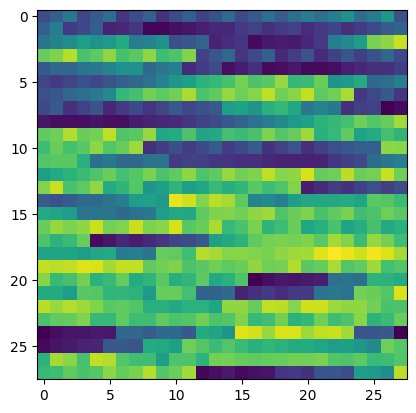

Real: 6
Predicted: 8
Rank of the correct answer: 2
Probabilities: [0.05907663 0.0546234  0.08265345 0.08652061 0.05086097 0.07591423
 0.1196415  0.05377271 0.25419275 0.10994549] 

Image no. 158


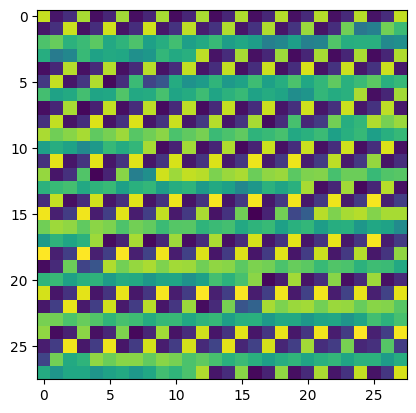

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.02001814  0.07708157 -0.12087508  0.26979461  0.15172181  0.18259769
  0.17205893  0.01630587  0.05042166  0.07760539] 

Image no. 159


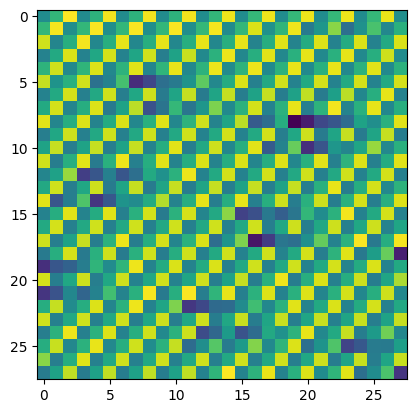

Real: 4
Predicted: 0
Rank of the correct answer: 4
Probabilities: [ 0.26947614  0.01344884  0.07889983  0.02821421  0.12320579 -0.03317255
 -0.04557819  0.19895298  0.15687938  0.09206281] 

Image no. 162


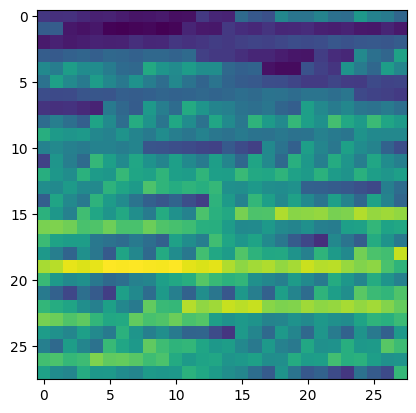

Real: 6
Predicted: 1
Rank of the correct answer: 8
Probabilities: [ 0.06519574  0.41166266  0.18744019  0.13231125  0.0844627   0.09559032
  0.02375768  0.17785844 -0.12037301 -0.02212948] 

Image no. 163


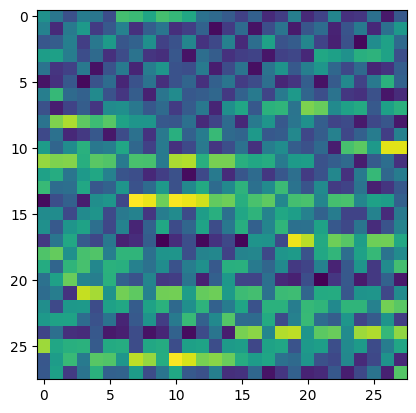

Real: 6
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.12275769 -0.01223071  0.2126959   0.02670113  0.32882191  0.11780244
  0.31385219  0.06735442  0.05034847 -0.01804645] 

Image no. 165


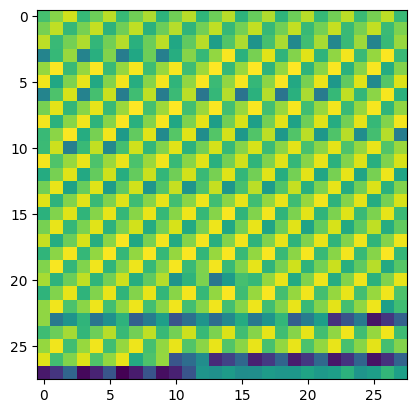

Real: 4
Predicted: 7
Rank of the correct answer: 4
Probabilities: [ 0.26130351 -0.06411153  0.056636    0.03888589  0.08401343  0.06906393
  0.01319953  0.42587623 -0.04055659  0.14142346] 

Image no. 167


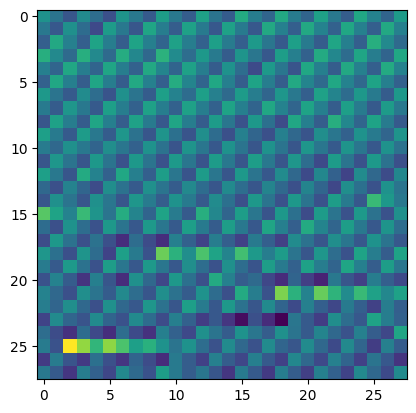

Real: 4
Predicted: 6
Rank of the correct answer: 2
Probabilities: [ 0.0501532  -0.04166652  0.16562418  0.10711961  0.22596877  0.07779748
  0.26992482  0.06551633  0.01702097 -0.02553615] 

Image no. 168


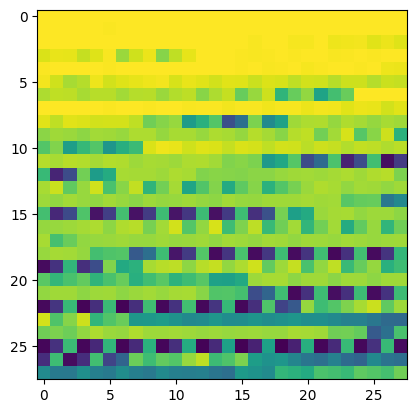

Real: 5
Predicted: 7
Rank of the correct answer: 3
Probabilities: [ 0.12560304 -0.02702608 -0.02105606  0.15558785 -0.01756035  0.16508212
  0.19085475  0.29451494  0.10645395  0.0933016 ] 

Image no. 169


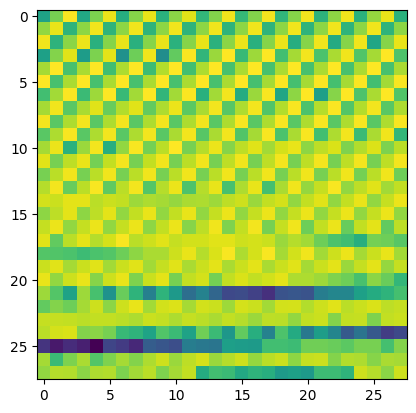

Real: 0
Predicted: 9
Rank of the correct answer: 3
Probabilities: [ 0.25090284 -0.05953014  0.0015369   0.02952174  0.04851787 -0.02515598
  0.07825123  0.25759808  0.08157194  0.36935991] 

Image no. 171


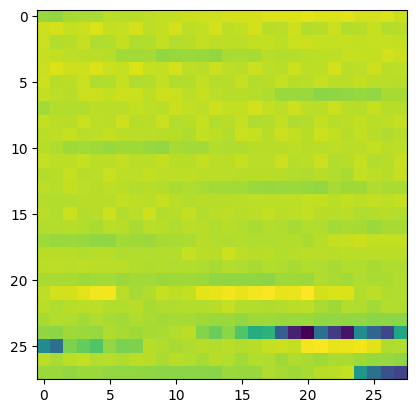

Real: 9
Predicted: 7
Rank of the correct answer: 3
Probabilities: [ 0.17226348 -0.0022052  -0.02163899  0.09961366  0.09573279  0.02777488
 -0.05792353  0.37993422  0.07183295  0.1305946 ] 

Image no. 172


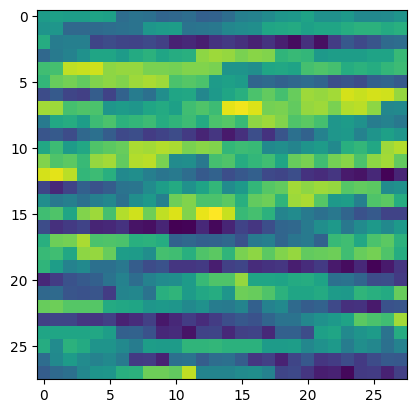

Real: 9
Predicted: 0
Rank of the correct answer: 6
Probabilities: [0.20730122 0.1840733  0.13841156 0.05080186 0.02869635 0.02077888
 0.09141581 0.01414773 0.12527157 0.06900303] 

Image no. 174


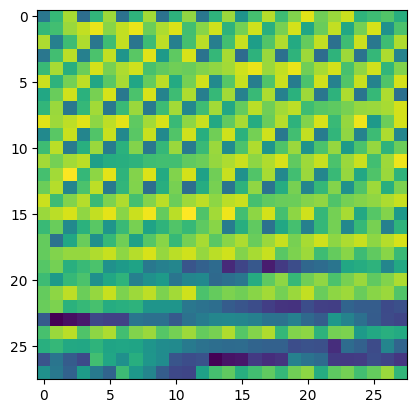

Real: 9
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.00654071  0.24019508 -0.01866761 -0.00418286  0.05422448  0.02086704
  0.20392595  0.17326265  0.05925037  0.22626926] 

Image no. 176


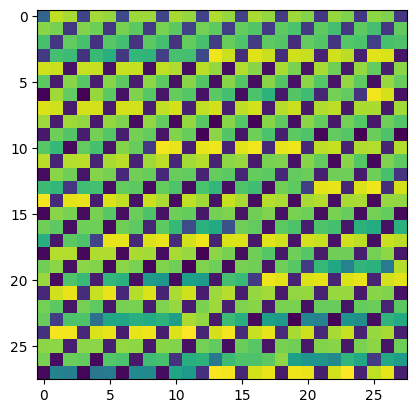

Real: 3
Predicted: 8
Rank of the correct answer: 6
Probabilities: [ 0.31421531  0.01769447  0.00497049  0.01907672  0.17872163  0.02746537
  0.20834923 -0.05886129  0.36865932 -0.00682175] 

Image no. 177


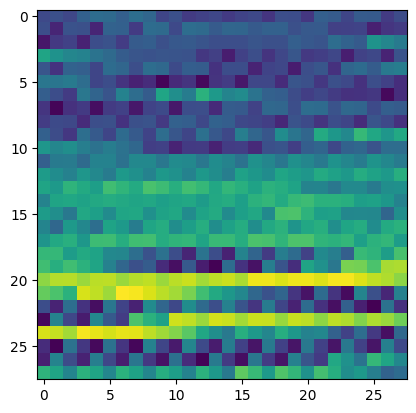

Real: 7
Predicted: 6
Rank of the correct answer: 4
Probabilities: [-0.08466411 -0.11253966  0.22994952  0.20318297  0.12158469  0.23686428
  0.26474178  0.22437625 -0.09131865 -0.00166739] 

Image no. 178


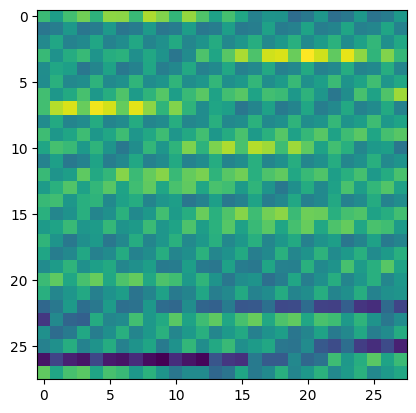

Real: 5
Predicted: 3
Rank of the correct answer: 3
Probabilities: [ 0.05533505  0.13104948  0.15549611  0.23197576  0.0647019   0.15237914
  0.04914312  0.06341676  0.04930149 -0.01537889] 

Image no. 179


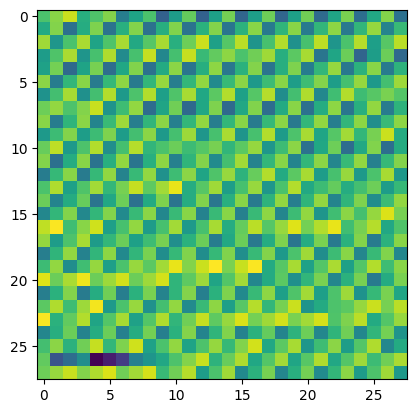

Real: 0
Predicted: 9
Rank of the correct answer: 5
Probabilities: [ 0.15010591  0.17266985  0.13508053 -0.01837143  0.07524781  0.00572446
 -0.04065311  0.16577143  0.15176854  0.19145306] 

Image no. 180


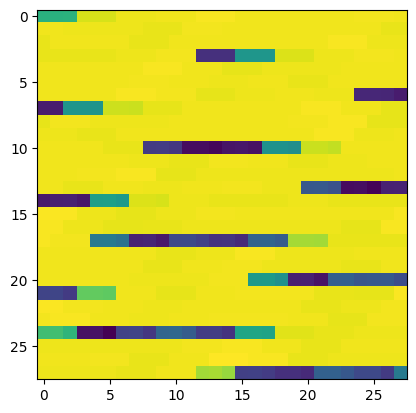

Real: 0
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.19644834  0.18254693 -0.046879    0.0970462  -0.00248202  0.02842481
  0.05850361  0.06823549  0.18488317  0.23934462] 

Image no. 181


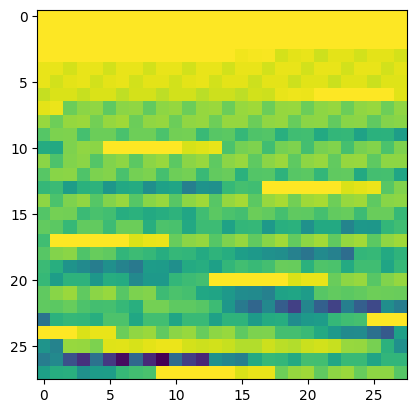

Real: 5
Predicted: 7
Rank of the correct answer: 4
Probabilities: [ 0.08315599  0.01772618 -0.07128104  0.16041174  0.11889893  0.14692672
  0.15582818  0.4041928  -0.01761115  0.0610819 ] 

Image no. 182


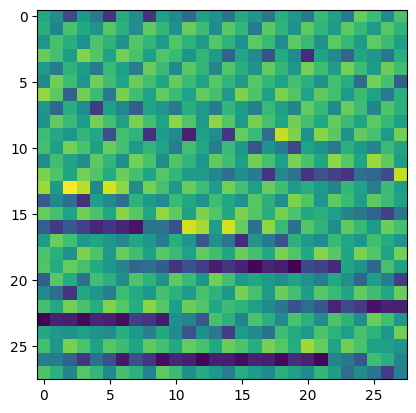

Real: 2
Predicted: 6
Rank of the correct answer: 4
Probabilities: [ 0.10627036 -0.08622503  0.143677    0.15862255  0.13643673  0.27283595
  0.48079945  0.02726342 -0.039817   -0.14723314] 

Image no. 183


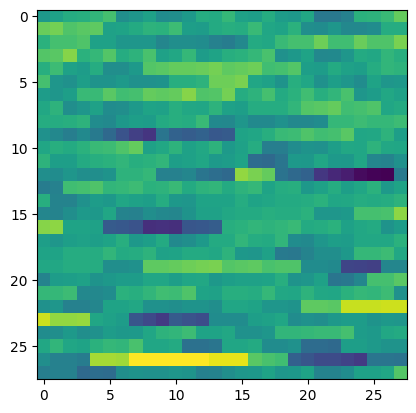

Real: 2
Predicted: 0
Rank of the correct answer: 2
Probabilities: [0.17843731 0.03265511 0.17191174 0.04463524 0.13039412 0.03361784
 0.09221023 0.03574701 0.1690403  0.05140623] 

Image no. 184


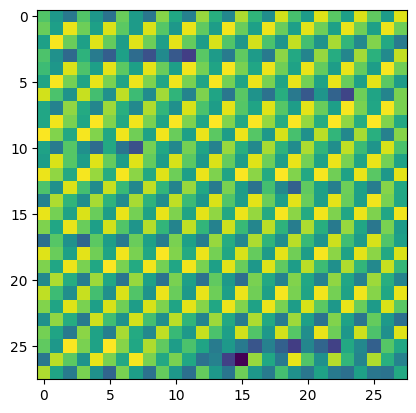

Real: 3
Predicted: 7
Rank of the correct answer: 4
Probabilities: [ 0.11832694 -0.06337321  0.14049284  0.14271638  0.07842553  0.23108267
  0.17572359  0.24072032 -0.00034249 -0.03823617] 

Image no. 187


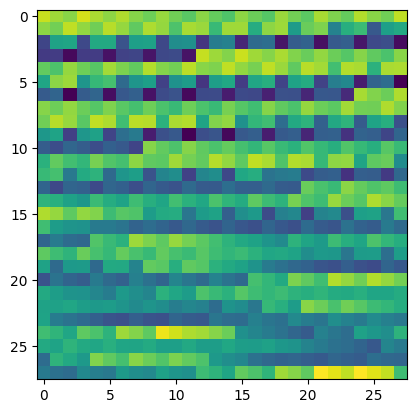

Real: 3
Predicted: 6
Rank of the correct answer: 4
Probabilities: [ 0.15583919  0.08439457  0.16533377  0.13053802  0.12417979  0.06102881
  0.18134327  0.06686475 -0.04441464  0.09730667] 

Image no. 188


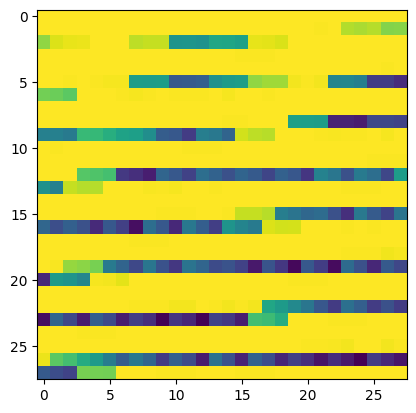

Real: 4
Predicted: 7
Rank of the correct answer: 5
Probabilities: [-0.113877   -0.0892745   0.05958312  0.2372406   0.12649368 -0.0098204
  0.33544067  0.35841468  0.05875684  0.17848008] 

Image no. 190


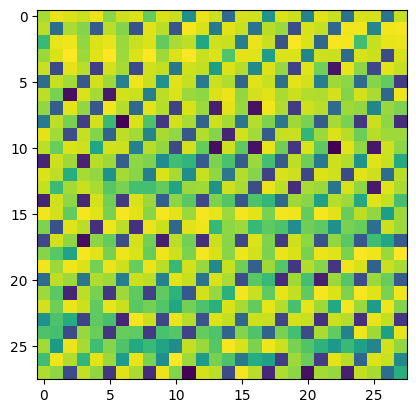

Real: 5
Predicted: 4
Rank of the correct answer: 7
Probabilities: [ 0.12429007  0.1452906   0.30413977  0.10870351  0.34003618  0.04978866
  0.15081738 -0.06325694  0.03212248 -0.03585324] 

Image no. 191


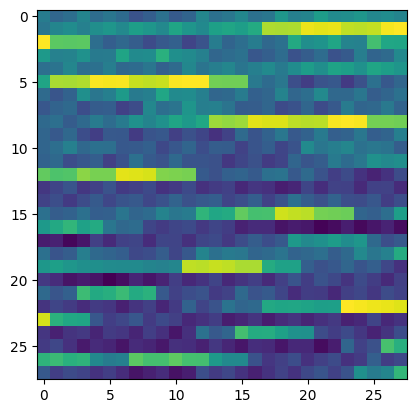

Real: 8
Predicted: 3
Rank of the correct answer: 10
Probabilities: [0.14082005 0.08891394 0.03698309 0.24311379 0.09406155 0.1328296
 0.05521199 0.05580257 0.02374543 0.08847143] 

Image no. 192


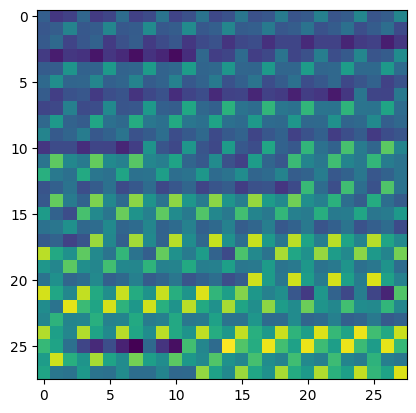

Real: 0
Predicted: 7
Rank of the correct answer: 9
Probabilities: [1.06666340e-02 8.24820548e-02 1.54892252e-01 6.97450585e-02
 1.00046867e-05 1.48617681e-01 1.00271412e-01 2.01361302e-01
 4.67320137e-02 2.00246573e-01] 

Image no. 193


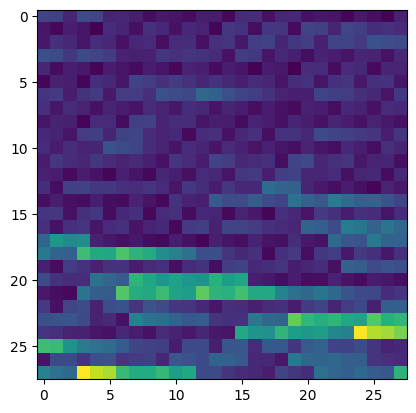

Real: 1
Predicted: 4
Rank of the correct answer: 4
Probabilities: [0.05964041 0.15499054 0.04713717 0.13209315 0.18628426 0.16397508
 0.090066   0.15872821 0.08437566 0.02874745] 

Image no. 195


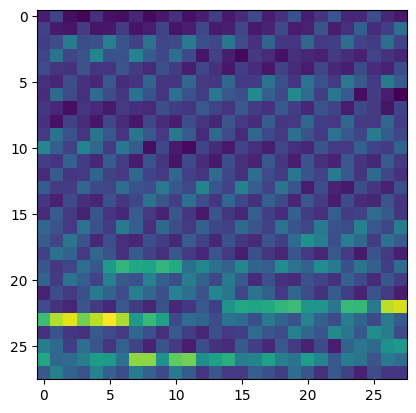

Real: 2
Predicted: 4
Rank of the correct answer: 3
Probabilities: [ 0.08895616  0.07500065  0.16007991  0.0868776   0.26968923  0.09473169
  0.17936714 -0.09847431  0.03446221 -0.00227702] 

Image no. 197


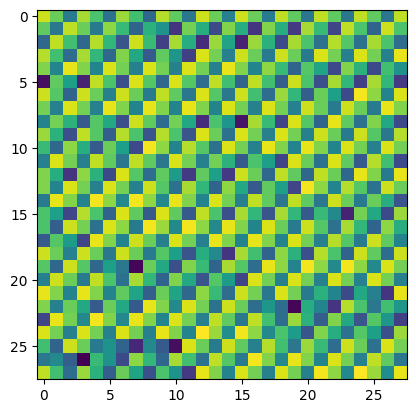

Real: 8
Predicted: 2
Rank of the correct answer: 3
Probabilities: [ 0.25351854 -0.04978665  0.33175926  0.09475905  0.14765175  0.07661987
  0.08446992 -0.00262053  0.20597517 -0.03403258] 

Image no. 199


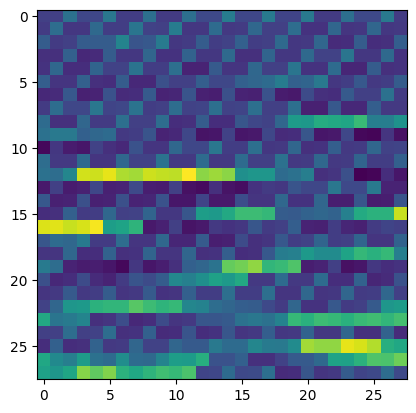

Real: 8
Predicted: 0
Rank of the correct answer: 8
Probabilities: [ 0.16927712  0.08493694  0.09243626  0.12918469  0.16376739  0.14862553
 -0.01463787  0.04476308  0.04789546  0.14863655] 



In [82]:
# Devoted solely to the MNIST dataset
def find_pos(item, lst):
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z]
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")